In [103]:
# Libraries
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pickle
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from dotenv import load_dotenv
from supabase import create_client, Client
import os

In [104]:
# Read data
load_dotenv()

SUPABASE_URL = os.getenv("NEXT_PUBLIC_SUPABASE_URL")
SUPABASE_SERVICE_KEY = os.getenv("NEXT_PUBLIC_SUPABASE_SERVICE_KEY")

supabase = create_client(SUPABASE_URL, SUPABASE_SERVICE_KEY)

MAKE = "Porsche"

response = (
    supabase.table("bat_completed_auctions")
    .select("year, model, mileage, normalized_color, transmission, sold_price, bid_amount, end_date, status")
    .eq("make", MAKE)
    .not_.is_("mileage", None)
    .not_.is_("transmission", None)
    .execute()
)
df = pd.DataFrame(response.data)

In [105]:
# Top Prices by model
prices = df[['model','sold_price']].groupby('model').mean().sort_values(by='sold_price',ascending=False)
print(prices)

                            sold_price
model                                 
910                          2500000.0
959 Komfort                  1641653.0
935                          1613000.0
Carrera GT                   1490709.5
962C                         1249620.0
...                                ...
Panamera Platinum Edition          NaN
Taycan 4S Cross Turismo            NaN
Taycan GTS                         NaN
Taycan Turbo Cross Turismo         NaN
Turbo S Cabriolet                  NaN

[817 rows x 1 columns]


In [106]:
# Price by model
display_p=df[['model','year','sold_price']]

fig=px.box(display_p,x="model",y="sold_price")
fig.update_layout(title_text='Price vs Model',xaxis_title="Model",yaxis_title="Average Price")

In [107]:
# Filter to models with more than min_observations
min_observations = 25
counts=df['model'].value_counts()
frequent_models = counts[counts >= min_observations].index

# Filter the data to frequent models
df = df[df['model'].isin(frequent_models)]
popular_labels=frequent_models

colors=['lightslategray',]*len(popular_labels)
colors[0]='crimson'

fig=go.Figure(data=[go.Bar(x=counts[:25],y=popular_labels,marker_color=colors,orientation='h')])
fig.update_layout(title_text='Most represented Models in the Dataset',xaxis_title="Count",yaxis_title="Model")

In [108]:
#distribution of number of cars over the years
dic = {1970+i : sum(df['year']==1970+i) for i in range(55)}
x_dic = [1970 + i for i in range(55)]
y_dic = [dic[1970 + i] for i in range(55)]

# Plot
fig = go.Figure([go.Bar(x=x_dic, y=y_dic)])

fig.update_layout(title="Car year distribution",
                  xaxis_title="Year",
                  yaxis_title="Count Cars sold")


fig.show()

In [109]:
# Distribution of transmission
data_pie = df['transmission'].value_counts()

fig = go.Figure(data=[go.Pie(labels=data_pie.index, values=data_pie.tolist(), textinfo='label+percent',insidetextorientation='radial')])

fig.update_traces(hole=.3, hoverinfo="label+percent+name")

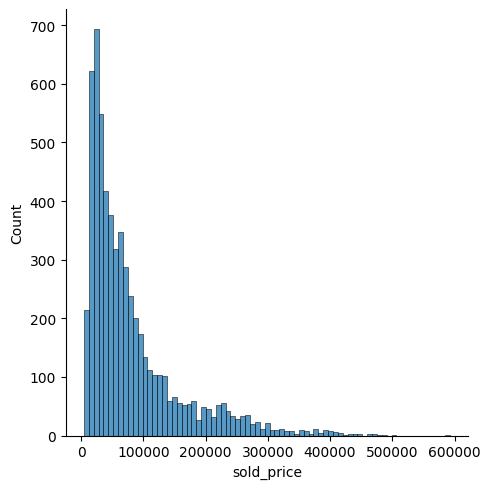

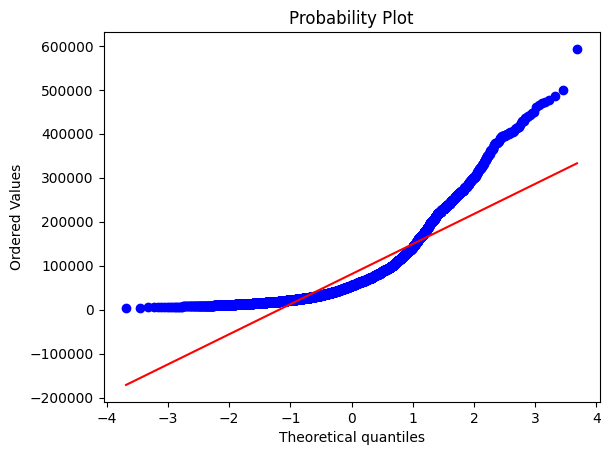

In [110]:
# Replace sold_price with bid_amount and remove outliers
df['sold_price'] = df['sold_price'].fillna(df['bid_amount'])
df = df.dropna()

# Remove outliers
price_threshold = 1000000
df.drop(df[df['sold_price'] >= price_threshold].index,inplace=True)

# Plot distribution of sold_price
sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'mileage'}>],
       [<Axes: title={'center': 'sold_price'}>,
        <Axes: title={'center': 'bid_amount'}>]], dtype=object)

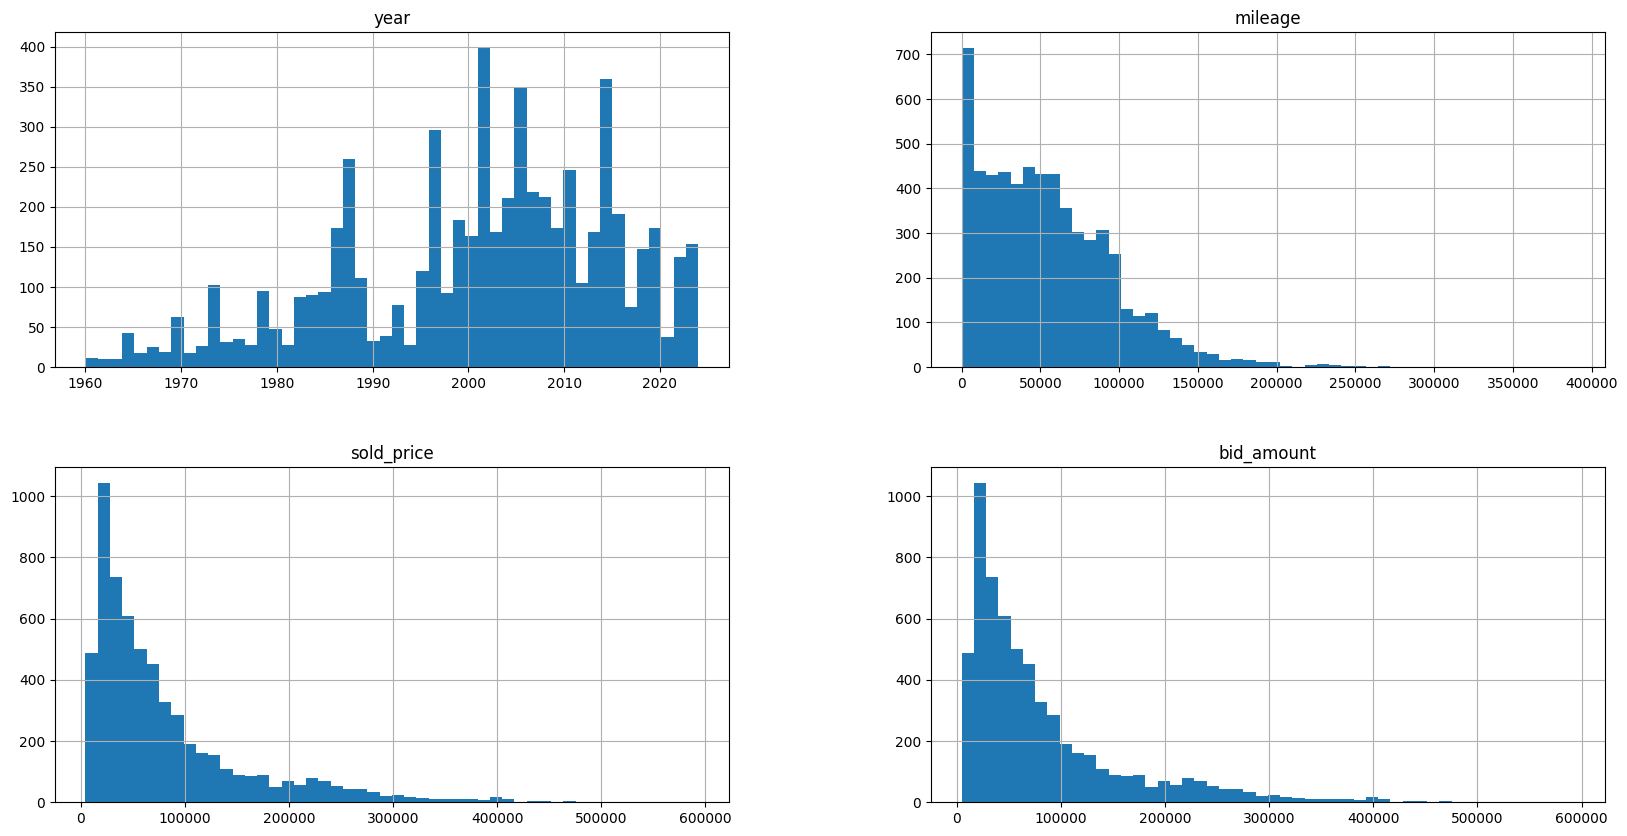

In [111]:
# Data distribution
df.hist(figsize=(20,10),bins = 50)

In [112]:
# Weight by recency
df['days_since_end'] = (pd.to_datetime(date.today()) - pd.to_datetime(df["end_date"])).dt.days
K = 1
T = 360
df['W'] = K*np.exp(-df['days_since_end']/T)


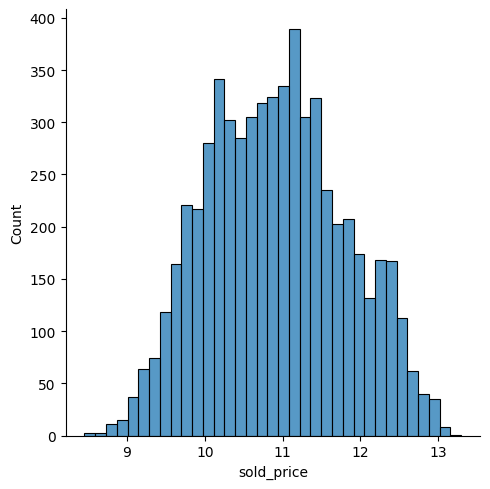

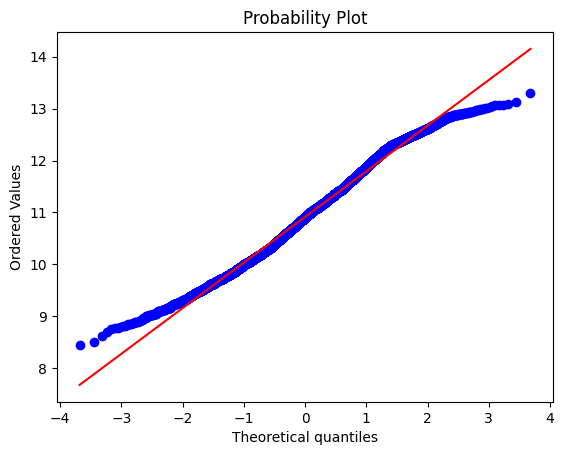

In [113]:
#Log transform sold_price & mileage
df['sold_price'] = np.log(df['sold_price'])
df['mileage'] = np.log1p(df['mileage'])

sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)

In [114]:
# Summarize transformed data
df.describe()

,year,mileage,sold_price,bid_amount,days_since_end,W
count,5977.000000,5977.000000,5977.000000,5977.000000,5977.000000,5977.000000
mean,2001.119793,10.395630,10.914780,80836.694997,369.216664,0.422634
std,14.034430,1.389863,0.882462,77211.410611,210.647551,0.236704
min,1960.000000,0.000000,8.455318,4700.000000,3.000000,0.129812
25%,1992.000000,9.998843,10.236382,27900.000000,190.000000,0.212838
50%,2003.000000,10.799596,10.905956,54500.000000,358.000000,0.369929
75%,2012.000000,11.289794,11.512925,100000.000000,557.000000,0.589914
max,2024.000000,12.871337,13.292950,593000.000000,735.000000,0.991701


In [115]:
# Prepare target and features
y = df["sold_price"]
X = df.drop(["sold_price","bid_amount","end_date", "status", "days_since_end"],axis=1)
X

,year,model,mileage,normalized_color,transmission,W
113,1963,356B Coupe,10.373522,Green,manual,0.258521
114,1961,356B Coupe,11.350418,Blue,manual,0.224997
115,1963,356B Coupe,10.518700,Blue,manual,0.220665
116,1961,356B Coupe,8.476580,Gray,manual,0.204152
117,1963,356B Coupe,10.691968,Silver,manual,0.203021
...,...,...,...,...,...,...
8653,2010,Panamera Turbo,10.933125,Blue,automatic,0.514845
8654,2012,Panamera Turbo,9.952325,Silver,automatic,0.454349
8655,2011,Panamera Turbo,9.741027,Blue,automatic,0.386741
8656,2013,Panamera Turbo,10.239996,White,automatic,0.358796


In [116]:
# Encode categorical features
Lbl_model = LabelEncoder()
Lbl_color = LabelEncoder()
Lbl_trans = LabelEncoder()

#df.make=Lbl.fit_transform(df.make)
X.model=Lbl_model.fit_transform(df.model)
print("Model Mapping:", dict(zip(Lbl_model.classes_, Lbl_model.transform(Lbl_model.classes_))))
X.normalized_color=Lbl_color.fit_transform(df.normalized_color)
print("Color Mapping:", dict(zip(Lbl_color.classes_, Lbl_color.transform(Lbl_color.classes_))))
X.transmission =Lbl_trans.fit_transform(df.transmission)
print("Trans Mapping:", dict(zip(Lbl_trans.classes_, Lbl_trans.transform(Lbl_trans.classes_))))
X

Model Mapping: {'356B Coupe': 0, '356C Coupe': 1, '718 Cayman GT4 RS Weissach': 2, '911 40th Anniversary 6-Speed': 3, '911 Carrera 2 Cabriolet 5-Speed': 4, '911 Carrera 2 Coupe 5-Speed': 5, '911 Carrera 4 Cabriolet 6-Speed': 6, '911 Carrera 4 Coupe 5-Speed': 7, '911 Carrera 4 Coupe 6-Speed': 8, '911 Carrera 4S 6-Speed': 9, '911 Carrera 4S Cabriolet': 10, '911 Carrera 4S Cabriolet 6-Speed': 11, '911 Carrera 4S Coupe': 12, '911 Carrera 4S Coupe 6-Speed': 13, '911 Carrera Cabriolet': 14, '911 Carrera Cabriolet 6-Speed': 15, '911 Carrera Cabriolet G50': 16, '911 Carrera Coupe': 17, '911 Carrera Coupe 6-Speed': 18, '911 Carrera Coupe G50': 19, '911 Carrera GTS Coupe': 20, '911 Carrera RS': 21, '911 Carrera S Cabriolet': 22, '911 Carrera S Cabriolet 6-Speed': 23, '911 Carrera S Coupe': 24, '911 Carrera S Coupe 6-Speed': 25, '911 Carrera S Coupe 7-Speed': 26, '911 Carrera Targa': 27, '911 Carrera Targa 6-Speed': 28, '911 Carrera Targa G50': 29, '911 Dakar': 30, '911 GT2 RS Weissach': 31, '911

,year,model,mileage,normalized_color,transmission,W
113,1963,0,10.373522,11,1,0.258521
114,1961,0,11.350418,2,1,0.224997
115,1963,0,10.518700,2,1,0.220665
116,1961,0,8.476580,10,1,0.204152
117,1963,0,10.691968,20,1,0.203021
...,...,...,...,...,...,...
8653,2010,79,10.933125,2,0,0.514845
8654,2012,79,9.952325,20,0,0.454349
8655,2011,79,9.741027,2,0,0.386741
8656,2013,79,10.239996,22,0,0.358796


In [127]:
# Fit Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle = True)

car_model_rf = RandomForestRegressor(n_estimators=150, random_state=33, monotonic_cst = [0,0,-1,0,0,0])
car_model_rf.fit(X_train,y_train, sample_weight=X_train['W'])
print('Random Forest Regressor Train Score is : ' ,  car_model_rf.score(X_train, y_train))
print('Random Forest Regressor Test Score is : ' , car_model_rf.score(X_test, y_test)) 

car_model_xgb = XGBRegressor(n_estimators=150, random_state=33)
car_model_xgb.fit(X_train,y_train, sample_weight=X_train['W'])
print('XGB Regressor Train Score is : ' ,  car_model_xgb.score(X_train, y_train))
print('XGB Regressor Test Score is : ' , car_model_xgb.score(X_test, y_test)) 

# Features
# year	model	mileage	normalized_color	transmission

predicted_xgb = pd.DataFrame(car_model_xgb.predict(X_test), index=X_test.index, columns=['predicted_xgb'])
predicted_rf = pd.DataFrame(car_model_rf.predict(X_test), index=X_test.index, columns=['predicted_rf'])
car_model_rf.feature_importances_

Random Forest Regressor Train Score is :  0.9448623936522139
Random Forest Regressor Test Score is :  0.904223099167123
XGB Regressor Train Score is :  0.9872923158922221
XGB Regressor Test Score is :  0.9148396009876913


array([0.26980009, 0.54312336, 0.13692472, 0.01319973, 0.00426999,
       0.03268211])

In [118]:
# Inverse transform features
X_analysis = X_test.copy()
X_analysis.model = Lbl_model.inverse_transform(X_test.model)
X_analysis.normalized_color = Lbl_color.inverse_transform(X_test.normalized_color)
X_analysis.transmission = Lbl_trans.inverse_transform(X_test.transmission)
X_analysis

,year,model,mileage,normalized_color,transmission,W
2691,2010,911 Carrera S Cabriolet 6-Speed,10.085851,Red,manual,0.202458
3186,1987,911 Carrera Targa G50,9.105091,Red,manual,0.548812
5002,1986,911 Turbo Coupe,10.985310,Red,manual,0.759572
2047,2000,911 Carrera Coupe 6-Speed,11.482477,Black,manual,0.277112
6833,2000,Boxster 5-Speed,9.392745,Red,manual,0.175228
...,...,...,...,...,...,...
1274,2008,911 Carrera 4S Coupe 6-Speed,10.819798,Gray,manual,0.142274
7350,2016,Cayenne,10.915107,Blue,automatic,0.160770
5258,2002,911 Turbo Coupe 6-Speed,10.085851,White,manual,0.948591
1617,2003,911 Carrera Cabriolet 6-Speed,11.302217,Blue,manual,0.362805


In [119]:
# Analyze Resulst: Add target and predicted values
X_analysis = pd.merge(y_test, X_analysis, how='inner', left_index=True, right_index=True)
X_analysis = pd.merge(X_analysis, predicted_xgb, how='inner', left_index=True, right_index=True)
X_analysis = pd.merge(X_analysis, predicted_rf, how='inner', left_index=True, right_index=True)
X_analysis.sold_price = np.exp(X_analysis.sold_price)
X_analysis.predicted_xgb = np.exp(X_analysis.predicted_xgb)
X_analysis.predicted_rf = np.exp(X_analysis.predicted_rf)
X_analysis.mileage = np.exp(X_analysis.mileage) - 1
X_analysis

,sold_price,year,model,mileage,normalized_color,transmission,W,predicted_xgb,predicted_rf
2691,68500.0,2010,911 Carrera S Cabriolet 6-Speed,24000.0,Red,manual,0.202458,65510.507812,75764.877444
3186,100000.0,1987,911 Carrera Targa G50,9000.0,Red,manual,0.548812,77803.593750,119008.716437
5002,113000.0,1986,911 Turbo Coupe,59000.0,Red,manual,0.759572,163558.140625,102634.761085
2047,23750.0,2000,911 Carrera Coupe 6-Speed,97000.0,Black,manual,0.277112,27283.123047,25659.959730
6833,18500.0,2000,Boxster 5-Speed,12000.0,Red,manual,0.175228,21408.417969,20260.235193
...,...,...,...,...,...,...,...,...,...
1274,65000.0,2008,911 Carrera 4S Coupe 6-Speed,50000.0,Gray,manual,0.142274,54500.277344,51135.204322
7350,29000.0,2016,Cayenne,55000.0,Blue,automatic,0.160770,29859.074219,35152.669194
5258,71500.0,2002,911 Turbo Coupe 6-Speed,24000.0,White,manual,0.948591,75474.507812,77614.320991
1617,25000.0,2003,911 Carrera Cabriolet 6-Speed,81000.0,Blue,manual,0.362805,26381.871094,27424.960909


In [120]:
# Define price ranges
def getrange(Price):
    if (Price >= 0 and Price < 50000):
        return '0 - 50000'
    if (Price >= 50000 and Price < 100000):
        return '50000 - 100000'
    if (Price >= 100000 and Price < 150000):
        return '100000 - 150000'
    if (Price >= 150000 and Price < 200000):
        return '150000 - 200000'
    if (Price >= 200000 and Price < 250000):
        return '200000 - 250000'
    if (Price >= 250000 and Price < 300000):
        return '250000 - 300000'
    if (Price >= 300000 and Price < 350000):
        return '300000 - 350000'
    if (Price >= 350000):
        return 'Over 350000'
X_analysis['Price Range'] = X_analysis['sold_price'].apply(lambda x:getrange(x))

X_analysis['Price Range'].value_counts()

Price Range
0 - 50000          562
50000 - 100000     350
100000 - 150000    123
150000 - 200000     55
200000 - 250000     48
250000 - 300000     33
Over 350000         16
300000 - 350000      9
Name: count, dtype: int64

<Axes: xlabel='sold_price', ylabel='predicted_rf'>

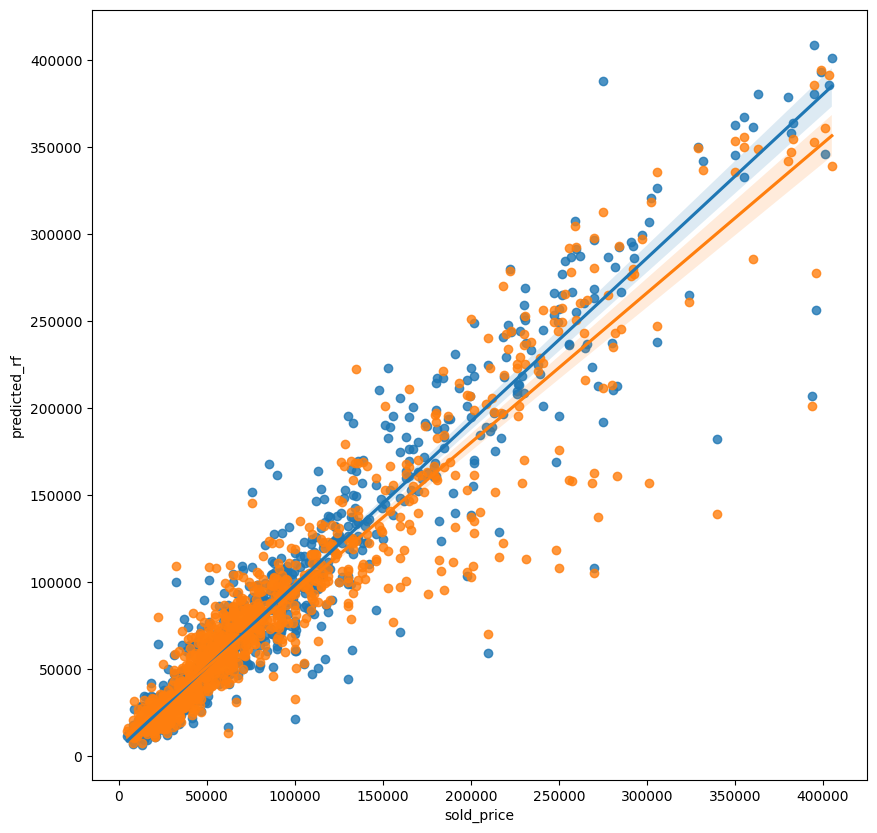

In [121]:
# Plot true vs predicted values scatter

plt.figure(figsize = (10, 10))
sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_xgb)
sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_rf)

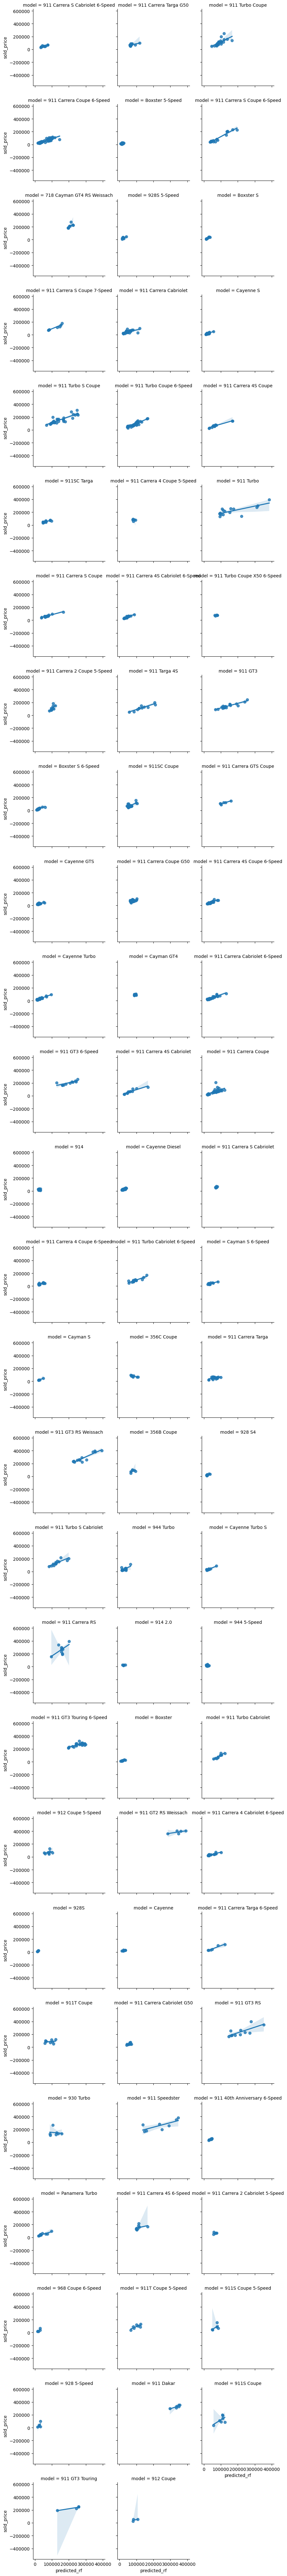

In [122]:
# Predicted vs Sold Price Scatter by model
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3)

# Map scatter plots to the grid
#g.map(sns.regplot, "predicted_xgb", "sold_price")
g.map(sns.regplot, "predicted_rf", "sold_price")

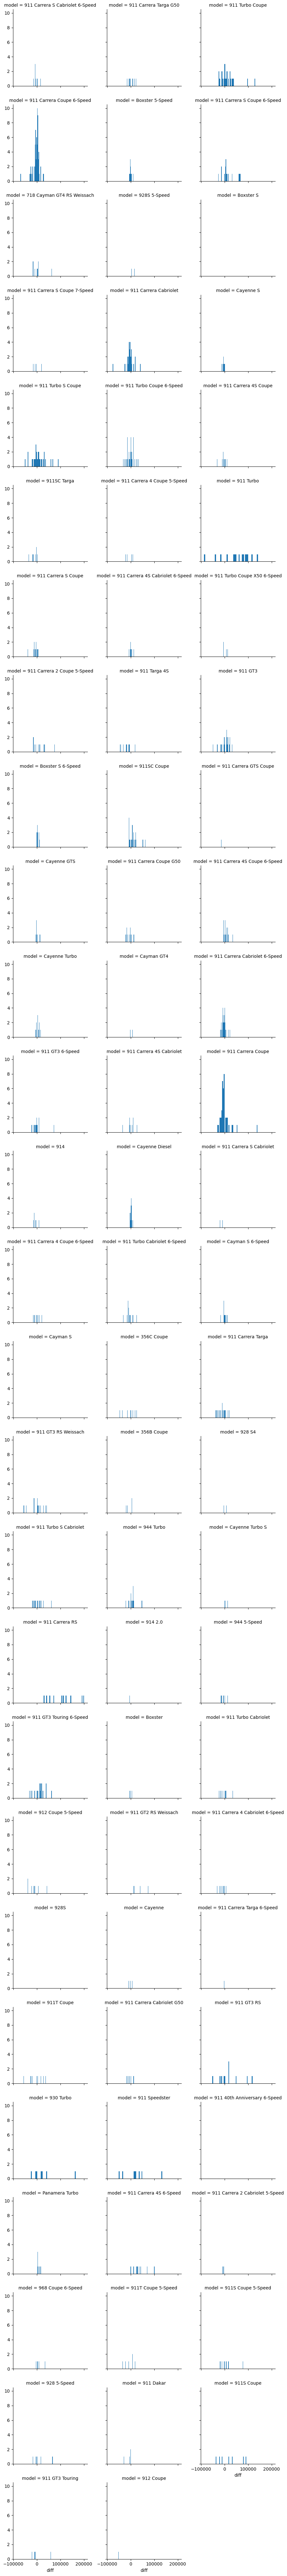

In [123]:
# Analyze Residuals by model
X_analysis['diff'] = X_analysis.sold_price - X_analysis.predicted_rf
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3)

# Map scatter plots to the grid
g.map(plt.hist, "diff", bins = 50)


In [124]:
# Prediction function

def predict(year, model, mileage, color, transmission, carmodel, W):
    input_data = pd.DataFrame([[year, model, mileage, color, transmission, W]], 
                              columns=["year", "model", "mileage", "normalized_color", "transmission", "W"])
    input_data.model=Lbl_model.transform(input_data.model)
    input_data.normalized_color=Lbl_color.transform(input_data.normalized_color)
    input_data.transmission=Lbl_trans.transform(input_data.transmission)
    input_data.mileage = np.log1p(input_data.mileage)
    price_scaled = carmodel.predict(input_data)

    price = np.exp(price_scaled)
    
    return price[0].round(0)

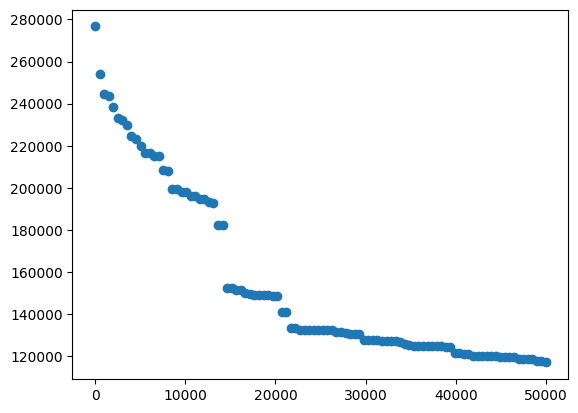

In [125]:
# Run a prediction for a car over a range of mileage
mileage_range = np.linspace(0, 50000, 100)

predictions = []
for mileage in mileage_range:
    prediction = predict(
        year = 2020,
        model = "911 GT3",
        mileage = mileage,
        color = "Silver",
        transmission = "manual",
        carmodel = car_model_rf,
        W = 1
    )
    predictions.append(prediction)

predictions = pd.DataFrame(predictions, columns=["predicted"])
mileage_range = pd.DataFrame(mileage_range, columns=["mileage"])
predictions = pd.merge(predictions, mileage_range, how='inner', left_index=True, right_index=True)
plt.scatter(predictions["mileage"], predictions["predicted"])

In [126]:
# Save model
pickle.dump(car_model_rf, open('model_porsche.pkl','wb'))